# RCT人工データ

In [1]:
import warnings
warnings.filterwarnings('error')
import pandas as pd
import numpy as np
from load_data import IHDP_Dataset, ArtificialData
from model import CFR
from optimize import MMD, train
from matplotlib import pyplot as plt
from dowhy import CausalModel

import torch
from torch.utils.data import DataLoader
from econml.dml import CausalForestDML
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.model_selection import train_test_split

### 人口データを用いた実験

In [2]:
# TODO: もう少し結果の見方を工夫する。可視化している結果が意味ない。
def view_causality_data_and_result(D, net, losses, legend=True):
    with torch.no_grad():
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

#         ax1.set_title('potential outcomes')
#         ax1.set_ylabel('$y$')
#         ax1.set_xlabel('$x$')
#         ax1.plot(D.X, D.mu0, label='$mu_0$', color='blue')
#         ax1.plot(D.X, D.mu1, label='$mu_1$', color='orange')

#         tau = D.mu1 - D.mu0
#         N = D.X.shape[0]
#         tau_hat = net(D.X, torch.ones(N))[1] - net(D.X, torch.zeros(N))[1]
#         ax2.set_ylabel('effect')
#         ax2.set_xlabel('$x$')
#         ax2.set_title('ground vs estimate for effect')
#         ax2.plot(D.X, tau, color='blue', label='ground')
#         ax2.plot(D.X, tau_hat, color='orange', label='predict')

        ax3.set_title('train loss')
        ax3.set_ylabel('loss')
        ax3.set_xlabel('steps')
        ax3.plot(losses)
        
        if legend:
            fig.legend()
        fig.tight_layout()
        plt.show()

In [3]:
# データの読み込み
ad_train_D = ArtificialData(mode=0, N=1000, seed=0)  # 訓練データ, mode=RCT, 定数効果
ad_test_D = ArtificialData(mode=0, N=1000, seed=1)  # テストデータ, mode=RCT, 定数効果
ate_true = torch.mean(ad_test_D.mu1 - ad_test_D.mu0)

shape check has been done.
shape check has been done.


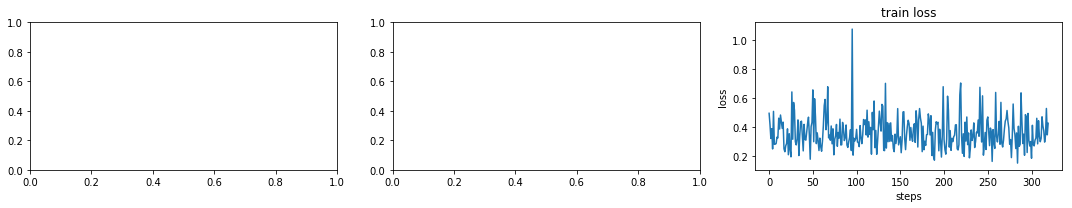

In [5]:
# CFR-NETの訓練
train_loader = DataLoader(ad_train_D, batch_size=32, shuffle=True)
cfr_net = CFR(feature_dim=2)
# FIXME: 損失がうまく低下しない, 考えられる可能性
#    1) 実装が間違っている。
#    2) そもそも解けない問題を解いている。
model, train_losses, _ = train(cfr_net, train_loader, learning_rate=1e-7, alpha=1, seed=100)
view_causality_data_and_result(ad_train_D, model, train_losses, legend=False)

In [12]:
# cfr netの
N = ad_test_D.X.shape[0]
estimate_cfr_net = torch.mean(cfr_net(ad_test_D.X, torch.ones(N))[1] - cfr_net(ad_test_D.X, torch.zeros(N))[1]).item()
print('ATE estimate of CFR-NET: ', estimate_cfr_net)

ATE estimate of CFR-NET:  0.002824630355462432


### Causal ForestによるITE, ATEの推定

In [6]:
# causal forestの訓練
covariates = ['x0', 'x1']
treatment = 'treatment'
outcome = 'yf'
label = covariates + [treatment, outcome]
df = pd.DataFrame(np.c_[ad_train_D.X, ad_train_D.t, ad_train_D.yf], columns=label)
model = CausalModel(data=df, treatment=treatment, outcome=outcome, common_causes=covariates, instruments=None, effect_modifiers=None)
# model.view_model()

train_data, test_data = train_test_split(df, test_size=0.2)

X_tr, Z_tr, Y_tr = train_data[covariates], train_data[treatment], train_data[outcome]
causal_forest = CausalForestDML(
    criterion='het',
    n_estimators=10000,
    min_samples_leaf=10,
    max_depth=None,
    max_samples=0.5,  # Q?: なぞ
    discrete_treatment=False,  # Q?: なぞ
    honest=True,  # Q?: Causal Treeを使うのですべてhonestでは？なぜわざわざ指定するオプションがある?
    inference=True,  # Q?: 推論しないなら何すんねん
    cv=10,
    model_t=LassoCV(),
    model_y=LassoCV()
)
causal_forest.fit(Y_tr, Z_tr, X=X_tr, W=None)  # Q?: Wがなぞ

In [1]:
# causal forestのテスト
X_test, Z_test, Yf_test = ad_test_D.X, ad_test_D.t, ad_test_D.yf
df = pd.DataFrame(np.c_[X_test, Z_test, Yf_test], columns=label)

estimate_causal_forest = causal_forest.const_marginal_ate(df[covariates])
print('ATE Estimate of Causal Forest: ', estimate_causal_forest)

print('ATE ERROR', 
print('PEHE = ', np.mean(causal_forest.effect(X=X_test, T1=Z_test, T0=1 - Z_test)**2)))

NameError: name 'ad_test_D' is not defined

In [2]:
causal_forest.effect_inference(X=X_test, T1=Z_test)

NameError: name 'causal_forest' is not defined

In [50]:
# OLSによるATEの推定
X_train = torch.stack([ad_train_D.X[:, 0], ad_train_D.X[:, 1], ad_train_D.t.float()], axis=1)
reg = LinearRegression()
reg.fit(X_train, ad_train_D.yf)

X_test_treat = torch.stack([ad_test_D.X[:, 0], ad_test_D.X[:, 1], torch.ones(ad_test_D.N)], axis=1)
y_hat_treat = torch.from_numpy(reg.predict(X_test_treat))

X_test_control = torch.stack([ad_test_D.X[:, 0], ad_test_D.X[:, 1], torch.zeros(ad_test_D.N)], axis=1)
y_hat_control = torch.from_numpy(reg.predict(X_test_control))

ate_hat = torch.mean(y_hat_treat - y_hat_control)
print('predict ate = ', ate_hat)

ate_error = torch.abs(ate_hat - ate_true).item()
print('error of ate', ate_error)

predict ate =  tensor(0.3000)
error of ate 2.9802322387695312e-08


### IHDPデータセットを用いた実験

In [1]:
# # データの読み込み
# train_D = IHDP_Dataset(train=True)
# train_loader = DataLoader(train_D, batch_size=32, shuffle=True)
# test_D = train_D = IHDP_Dataset(train=False)
# print('number of batch: ', len(train_loader))
# x = train_D.x
# cfr_net = CFR(feature_dim=x.shape[1])
# model, train_losses, _ = train(cfr_net, train_loader)
# view_causality_data_and_result(train_D, model, train_losses, legend=False)